# Notebook 03: Differential Expression Analysis

**Kairos Therapeutics ML Prototype V0**

---

## Purpose
Identify genes significantly differentially expressed between OA and Control cartilage:
1. Calculate fold changes and statistical significance
2. Apply multiple testing correction (FDR)
3. Generate volcano plot for visualization
4. Create ranked gene lists for downstream analysis

## Inputs
- `data/processed/GSE114007_metadata.csv`
- `data/processed/GSE114007_ml_matrix.csv` (z-scored)
- `data/processed/GSE114007_raw_source_matrix.csv` (log2 normalized)

## Outputs
- `data/processed/GSE114007_diff_expr_results.csv` (full results)
- `data/processed/GSE114007_significant_genes.csv` (filtered)
- `reports/figures/volcano_plot.png`
- `reports/figures/top_genes_heatmap.png`
- `reports/diff_expr_summary.txt`

## Method
- Welch's t-test (unequal variance) for each gene
- Benjamini-Hochberg FDR correction
- Significance threshold: FDR < 0.05, |log2FC| > 1

## Author
Pat Ovando-Roche, PhD | Kairos Therapeutics

## Version
v0.1 | December 2025

---
## Cell 1: Setup and Load Data

In [1]:
"""
CELL 1: SETUP AND LOAD DATA
===========================
Load processed data from Notebook 01.
"""

import os
import warnings
from pathlib import Path
from datetime import datetime

warnings.filterwarnings('ignore')

# Core data science
import numpy as np
import pandas as pd

# Statistics
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# --- Determine paths ---
NOTEBOOK_DIR = Path(os.getcwd())
if NOTEBOOK_DIR.name == 'notebooks':
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
FIGURES_DIR = PROJECT_ROOT / 'reports' / 'figures'
REPORTS_DIR = PROJECT_ROOT / 'reports'

# Create output directories
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("="*60)
print("NOTEBOOK 03: DIFFERENTIAL EXPRESSION ANALYSIS")
print("="*60)
print()
print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📁 Data folder: {DATA_PROCESSED}")
print(f"📁 Figures folder: {FIGURES_DIR}")
print()

# --- Load data ---
print("📥 Loading processed data...")
print()

try:
    metadata_df = pd.read_csv(DATA_PROCESSED / 'GSE114007_metadata.csv')
    print(f"   ✅ Metadata: {metadata_df.shape}")
except FileNotFoundError:
    print(f"   ❌ Metadata not found")
    metadata_df = None

try:
    # Use raw_source_matrix for DE (log2 values, not z-scored)
    expression_df = pd.read_csv(DATA_PROCESSED / 'GSE114007_raw_source_matrix.csv', index_col=0)
    print(f"   ✅ Expression matrix: {expression_df.shape}")
except FileNotFoundError:
    print(f"   ❌ Expression matrix not found")
    expression_df = None

print()
print(f"🕐 Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()
print("✅ Cell 1 complete. Ready for Cell 2.")

NOTEBOOK 03: DIFFERENTIAL EXPRESSION ANALYSIS

📁 Project root: C:\Users\povan\Kairos_Therapeutics
📁 Data folder: C:\Users\povan\Kairos_Therapeutics\data\processed
📁 Figures folder: C:\Users\povan\Kairos_Therapeutics\reports\figures

📥 Loading processed data...

   ✅ Metadata: (38, 9)
   ✅ Expression matrix: (23710, 38)

🕐 Started: 2025-12-26 19:06:39

✅ Cell 1 complete. Ready for Cell 2.


---
## Cell 2: Prepare Sample Groups

In [3]:
"""
CELL 2: PREPARE SAMPLE GROUPS
=============================
Split samples into OA and Control groups for comparison.
"""

print("📊 PREPARING SAMPLE GROUPS")
print("="*60)
print()

if metadata_df is not None and expression_df is not None:
    # Create sample info aligned to expression columns
    # Keep sample_id as a column (don't use set_index)
    sample_order = expression_df.columns.tolist()
    sample_info = metadata_df[metadata_df['sample_id'].isin(sample_order)].copy()
    sample_info = sample_info.set_index('sample_id').loc[sample_order].reset_index()
    
    # Get sample IDs for each group
    oa_samples = sample_info[sample_info['condition'] == 'OA']['sample_id'].tolist()
    ctrl_samples = sample_info[sample_info['condition'] == 'Control']['sample_id'].tolist()
    
    print(f"   OA samples: {len(oa_samples)}")
    print(f"   Control samples: {len(ctrl_samples)}")
    print()
    
    # Extract expression matrices for each group
    expr_oa = expression_df[oa_samples]
    expr_ctrl = expression_df[ctrl_samples]
    
    print(f"   OA expression matrix: {expr_oa.shape}")
    print(f"   Control expression matrix: {expr_ctrl.shape}")
    print()
    
    # Quick sanity check
    print("   📈 Expression summary:")
    print(f"      OA mean (all genes): {expr_oa.values.mean():.2f}")
    print(f"      Control mean (all genes): {expr_ctrl.values.mean():.2f}")

else:
    print("   ❌ Data not loaded properly")

print()
print("✅ Cell 2 complete. Ready for Cell 3.")

📊 PREPARING SAMPLE GROUPS

   OA samples: 20
   Control samples: 18

   OA expression matrix: (23710, 20)
   Control expression matrix: (23710, 18)

   📈 Expression summary:
      OA mean (all genes): 2.41
      Control mean (all genes): 2.39

✅ Cell 2 complete. Ready for Cell 3.


---
## Cell 3: Differential Expression Analysis

In [4]:
"""
CELL 3: DIFFERENTIAL EXPRESSION ANALYSIS
========================================
For each gene:
- Calculate mean expression in OA and Control
- Calculate log2 fold change (OA vs Control)
- Perform Welch's t-test
- Apply FDR correction
"""

print("🧬 DIFFERENTIAL EXPRESSION ANALYSIS")
print("="*60)
print()

print("   Computing differential expression for each gene...")
print("   (This may take a minute for ~24,000 genes)")
print()

# Initialize results lists
results = []

# Get gene list
genes = expression_df.index.tolist()
n_genes = len(genes)

# Progress tracking
progress_interval = n_genes // 10

for i, gene in enumerate(genes):
    # Get expression values for this gene
    oa_vals = expr_oa.loc[gene].values
    ctrl_vals = expr_ctrl.loc[gene].values
    
    # Calculate means
    mean_oa = np.mean(oa_vals)
    mean_ctrl = np.mean(ctrl_vals)
    
    # Calculate standard deviations
    std_oa = np.std(oa_vals, ddof=1)
    std_ctrl = np.std(ctrl_vals, ddof=1)
    
    # Log2 fold change (data is already log2, so difference = log2 fold change)
    log2fc = mean_oa - mean_ctrl
    
    # Welch's t-test (unequal variance)
    # Handle edge case where variance is zero
    if std_oa == 0 and std_ctrl == 0:
        t_stat = 0
        p_value = 1.0
    else:
        t_stat, p_value = stats.ttest_ind(oa_vals, ctrl_vals, equal_var=False)
    
    # Handle NaN p-values
    if np.isnan(p_value):
        p_value = 1.0
    
    results.append({
        'gene': gene,
        'mean_OA': mean_oa,
        'mean_Control': mean_ctrl,
        'std_OA': std_oa,
        'std_Control': std_ctrl,
        'log2FC': log2fc,
        't_statistic': t_stat,
        'p_value': p_value
    })
    
    # Progress update
    if (i + 1) % progress_interval == 0:
        print(f"      Processed {i+1:,}/{n_genes:,} genes ({100*(i+1)/n_genes:.0f}%)")

# Create results DataFrame
de_results = pd.DataFrame(results)

print()
print(f"   ✅ Completed analysis for {len(de_results):,} genes")
print()
print("✅ Cell 3 complete. Ready for Cell 4.")

🧬 DIFFERENTIAL EXPRESSION ANALYSIS

   Computing differential expression for each gene...
   (This may take a minute for ~24,000 genes)

      Processed 2,371/23,710 genes (10%)
      Processed 4,742/23,710 genes (20%)
      Processed 7,113/23,710 genes (30%)
      Processed 9,484/23,710 genes (40%)
      Processed 11,855/23,710 genes (50%)
      Processed 14,226/23,710 genes (60%)
      Processed 16,597/23,710 genes (70%)
      Processed 18,968/23,710 genes (80%)
      Processed 21,339/23,710 genes (90%)
      Processed 23,710/23,710 genes (100%)

   ✅ Completed analysis for 23,710 genes

✅ Cell 3 complete. Ready for Cell 4.


---
## Cell 4: Multiple Testing Correction

In [5]:
"""
CELL 4: MULTIPLE TESTING CORRECTION
===================================
Apply Benjamini-Hochberg FDR correction to p-values.
"""

print("📊 MULTIPLE TESTING CORRECTION")
print("="*60)
print()

# Apply Benjamini-Hochberg FDR correction
print("   Applying Benjamini-Hochberg FDR correction...")

rejected, fdr_values, _, _ = multipletests(
    de_results['p_value'].values,
    method='fdr_bh',
    alpha=0.05
)

de_results['FDR'] = fdr_values
de_results['significant_FDR'] = rejected

# Also calculate -log10(p-value) for volcano plot
de_results['neg_log10_pval'] = -np.log10(de_results['p_value'].clip(lower=1e-300))
de_results['neg_log10_FDR'] = -np.log10(de_results['FDR'].clip(lower=1e-300))

# Add significance categories
def classify_significance(row):
    if row['FDR'] < 0.05 and abs(row['log2FC']) > 1:
        if row['log2FC'] > 0:
            return 'Up in OA'
        else:
            return 'Down in OA'
    else:
        return 'Not significant'

de_results['significance'] = de_results.apply(classify_significance, axis=1)

# Summary
print()
print("   📈 RESULTS SUMMARY")
print("   " + "-"*50)
print(f"   Total genes tested: {len(de_results):,}")
print()
print(f"   Significant (FDR < 0.05): {de_results['significant_FDR'].sum():,}")
print(f"   Significant (FDR < 0.05 AND |log2FC| > 1): {(de_results['significance'] != 'Not significant').sum():,}")
print()
print("   By direction:")
for sig_type in ['Up in OA', 'Down in OA', 'Not significant']:
    count = (de_results['significance'] == sig_type).sum()
    print(f"      {sig_type}: {count:,}")

# Sort by significance
de_results = de_results.sort_values('p_value')

print()
print("✅ Cell 4 complete. Ready for Cell 5.")

📊 MULTIPLE TESTING CORRECTION

   Applying Benjamini-Hochberg FDR correction...

   📈 RESULTS SUMMARY
   --------------------------------------------------
   Total genes tested: 23,710

   Significant (FDR < 0.05): 3,270
   Significant (FDR < 0.05 AND |log2FC| > 1): 1,269

   By direction:
      Up in OA: 642
      Down in OA: 627
      Not significant: 22,441

✅ Cell 4 complete. Ready for Cell 5.


---
## Cell 5: Top Differentially Expressed Genes

In [ ]:
"""
CELL 5: TOP DIFFERENTIALLY EXPRESSED GENES
==========================================
Show the most significantly changed genes.
"""

print("🔝 TOP DIFFERENTIALLY EXPRESSED GENES")
print("="*60)
print()

# Filter significant genes
sig_genes = de_results[de_results['significance'] != 'Not significant'].copy()

# Top upregulated in OA
up_in_oa = sig_genes[sig_genes['significance'] == 'Up in OA'].sort_values('log2FC', ascending=False)

# Top downregulated in OA
down_in_oa = sig_genes[sig_genes['significance'] == 'Down in OA'].sort_values('log2FC', ascending=True)

print("📈 TOP 15 UPREGULATED IN OA (vs Control)")
print("-"*60)
print(f"{'Gene':<15} {'log2FC':>10} {'FDR':>12} {'Mean OA':>10} {'Mean Ctrl':>10}")
print("-"*60)
for _, row in up_in_oa.head(15).iterrows():
    print(f"{row['gene']:<15} {row['log2FC']:>10.2f} {row['FDR']:>12.2e} {row['mean_OA']:>10.2f} {row['mean_Control']:>10.2f}")

print()
print("📉 TOP 15 DOWNREGULATED IN OA (vs Control)")
print("-"*60)
print(f"{'Gene':<15} {'log2FC':>10} {'FDR':>12} {'Mean OA':>10} {'Mean Ctrl':>10}")
print("-"*60)
for _, row in down_in_oa.head(15).iterrows():
    print(f"{row['gene']:<15} {row['log2FC']:>10.2f} {row['FDR']:>12.2e} {row['mean_OA']:>10.2f} {row['mean_Control']:>10.2f}")

print()
print("✅ Cell 5 complete. Ready for Cell 6.")

---
## Cell 6: Volcano Plot

🌋 GENERATING VOLCANO PLOT

   💾 Saved: C:\Users\povan\Kairos_Therapeutics\reports\figures\volcano_plot.png


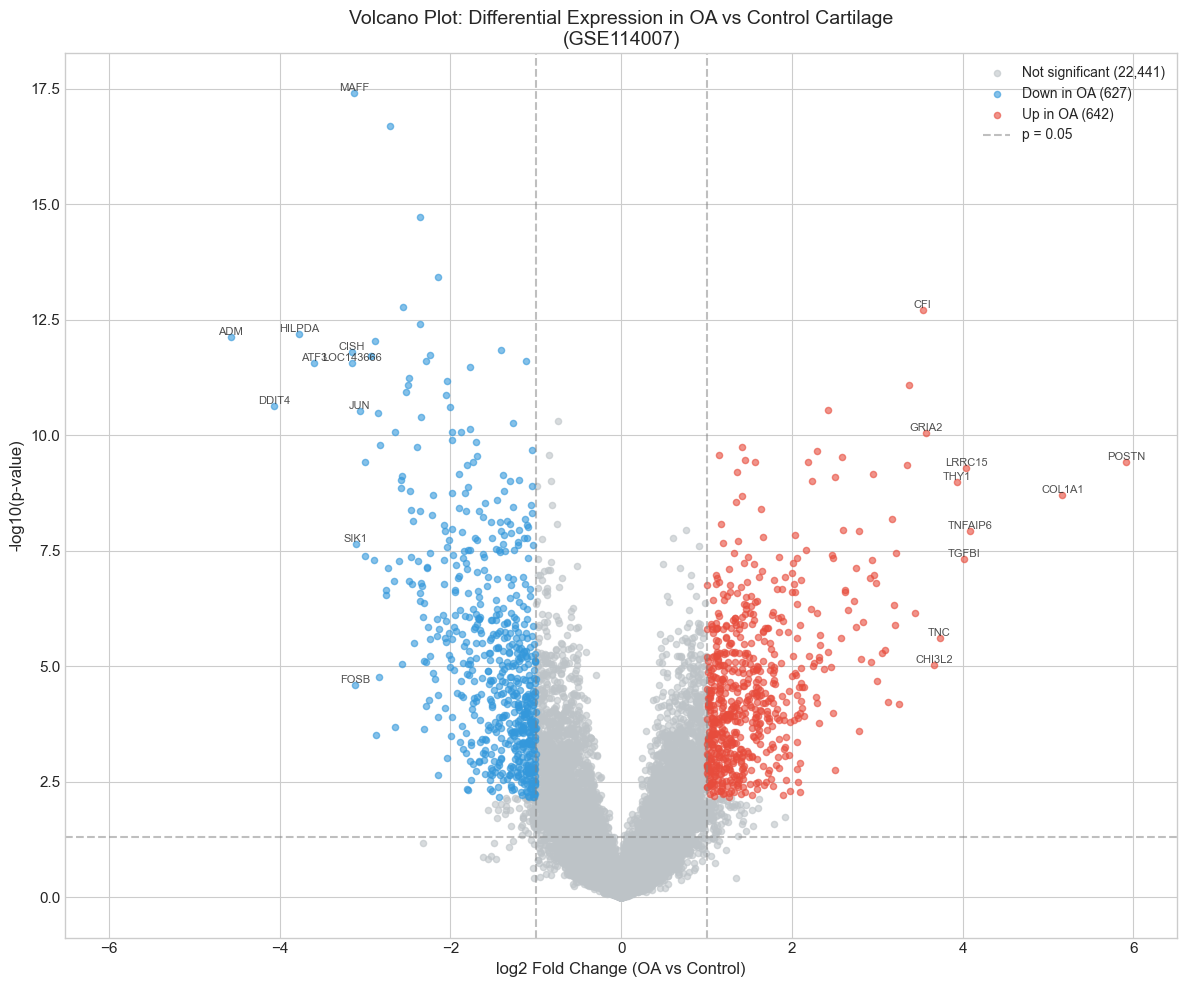


✅ Cell 6 complete. Ready for Cell 7.


In [6]:
"""
CELL 6: VOLCANO PLOT
====================
Visualize differential expression: log2FC vs -log10(p-value)
"""

print("🌋 GENERATING VOLCANO PLOT")
print("="*60)
print()

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Color mapping
colors = {
    'Up in OA': '#e74c3c',      # Red
    'Down in OA': '#3498db',    # Blue
    'Not significant': '#bdc3c7'  # Gray
}

# Plot each category
for sig_type in ['Not significant', 'Down in OA', 'Up in OA']:
    mask = de_results['significance'] == sig_type
    ax.scatter(
        de_results.loc[mask, 'log2FC'],
        de_results.loc[mask, 'neg_log10_pval'],
        c=colors[sig_type],
        label=f"{sig_type} ({mask.sum():,})",
        alpha=0.6,
        s=20
    )

# Add threshold lines
ax.axhline(y=-np.log10(0.05), color='gray', linestyle='--', alpha=0.5, label='p = 0.05')
ax.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=-1, color='gray', linestyle='--', alpha=0.5)

# Label top genes
n_labels = 10
top_up = de_results[de_results['significance'] == 'Up in OA'].nlargest(n_labels, 'log2FC')
top_down = de_results[de_results['significance'] == 'Down in OA'].nsmallest(n_labels, 'log2FC')

for _, row in pd.concat([top_up, top_down]).iterrows():
    ax.annotate(
        row['gene'],
        (row['log2FC'], row['neg_log10_pval']),
        fontsize=8,
        alpha=0.8,
        ha='center',
        va='bottom'
    )

# Labels and title
ax.set_xlabel('log2 Fold Change (OA vs Control)', fontsize=12)
ax.set_ylabel('-log10(p-value)', fontsize=12)
ax.set_title('Volcano Plot: Differential Expression in OA vs Control Cartilage\n(GSE114007)', fontsize=14)
ax.legend(loc='upper right', fontsize=10)

# Set axis limits
max_fc = max(abs(de_results['log2FC'].min()), abs(de_results['log2FC'].max())) * 1.1
ax.set_xlim(-max_fc, max_fc)

plt.tight_layout()

# Save figure
fig_path = FIGURES_DIR / 'volcano_plot.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"   💾 Saved: {fig_path}")

plt.show()

print()
print("✅ Cell 6 complete. Ready for Cell 7.")

---
## Cell 7: Key Therapeutic Target Genes

In [7]:
"""
CELL 7: KEY THERAPEUTIC TARGET GENES
====================================
Check differential expression of genes relevant to Kairos therapeutic hypothesis.
"""

print("🎯 KEY THERAPEUTIC TARGET GENES")
print("="*60)
print()

# Define key genes of interest
KEY_GENES = [
    'PF4',       # Anti-aging factor (Pinho 2025)
    'COL2A1',    # Type II collagen
    'ACAN',      # Aggrecan
    'MMP13',     # Matrix metalloproteinase
    'IL1B',      # Pro-inflammatory
    'IL6',       # Pro-inflammatory
    'TNF',       # Pro-inflammatory
    'SOX9',      # Chondrogenic TF
    'COMP',      # Cartilage matrix
    'PRG4',      # Lubricin
    'ADAMTS5',   # Aggrecanase
    'ADAMTS4',   # Aggrecanase
    'MMP3',      # Matrix metalloproteinase
    'TGFB1',     # Growth factor
    'BMP2',      # Growth factor
    'RUNX2',     # Osteogenic TF (bad for cartilage)
    'COL10A1',   # Hypertrophic marker
    'VEGFA',     # Angiogenic factor
]

# Look up each gene
print(f"{'Gene':<12} {'log2FC':>10} {'p-value':>12} {'FDR':>12} {'Status':>20}")
print("-"*70)

key_gene_results = []

for gene in KEY_GENES:
    if gene in de_results['gene'].values:
        row = de_results[de_results['gene'] == gene].iloc[0]
        status = row['significance']
        print(f"{gene:<12} {row['log2FC']:>10.2f} {row['p_value']:>12.2e} {row['FDR']:>12.2e} {status:>20}")
        key_gene_results.append(row)
    else:
        print(f"{gene:<12} {'N/A':>10} {'N/A':>12} {'N/A':>12} {'Not in dataset':>20}")

print("-"*70)

# Biological interpretation
print()
print("🔬 BIOLOGICAL INTERPRETATION")
print("-"*50)

key_gene_df = pd.DataFrame(key_gene_results)

if len(key_gene_df) > 0:
    # Categorize findings
    up_genes = key_gene_df[key_gene_df['log2FC'] > 0.5]['gene'].tolist()
    down_genes = key_gene_df[key_gene_df['log2FC'] < -0.5]['gene'].tolist()
    
    print()
    print("   ELEVATED in OA (bad actors):")
    for g in up_genes:
        fc = key_gene_df[key_gene_df['gene'] == g]['log2FC'].values[0]
        print(f"      • {g}: +{fc:.2f} log2FC")
    
    print()
    print("   REDUCED in OA (protective factors lost):")
    for g in down_genes:
        fc = key_gene_df[key_gene_df['gene'] == g]['log2FC'].values[0]
        print(f"      • {g}: {fc:.2f} log2FC")

print()
print("✅ Cell 7 complete. Ready for Cell 8.")

🎯 KEY THERAPEUTIC TARGET GENES

Gene             log2FC      p-value          FDR               Status
----------------------------------------------------------------------
PF4                0.06     2.31e-01     5.19e-01      Not significant
COL2A1             2.78     2.47e-04     4.16e-03             Up in OA
ACAN               0.08     6.92e-01     9.14e-01      Not significant
MMP13              3.20     4.82e-07     4.09e-05             Up in OA
IL1B               0.11     2.18e-01     5.03e-01      Not significant
IL6               -0.27     2.04e-01     4.85e-01      Not significant
TNF                0.23     1.24e-01     3.68e-01      Not significant
SOX9              -2.07     8.80e-09     1.95e-06           Down in OA
COMP               0.60     1.96e-01     4.74e-01      Not significant
PRG4              -0.70     1.52e-01     4.18e-01      Not significant
ADAMTS5            1.93     5.82e-05     1.40e-03             Up in OA
ADAMTS4           -0.03     9.54e-01     1.00

---
## Cell 8: Heatmap of Top DE Genes

📊 GENERATING TOP GENES HEATMAP

   Selecting top 50 DE genes by |log2FC|...
   Genes selected: 50

   💾 Saved: C:\Users\povan\Kairos_Therapeutics\reports\figures\top_genes_heatmap.png


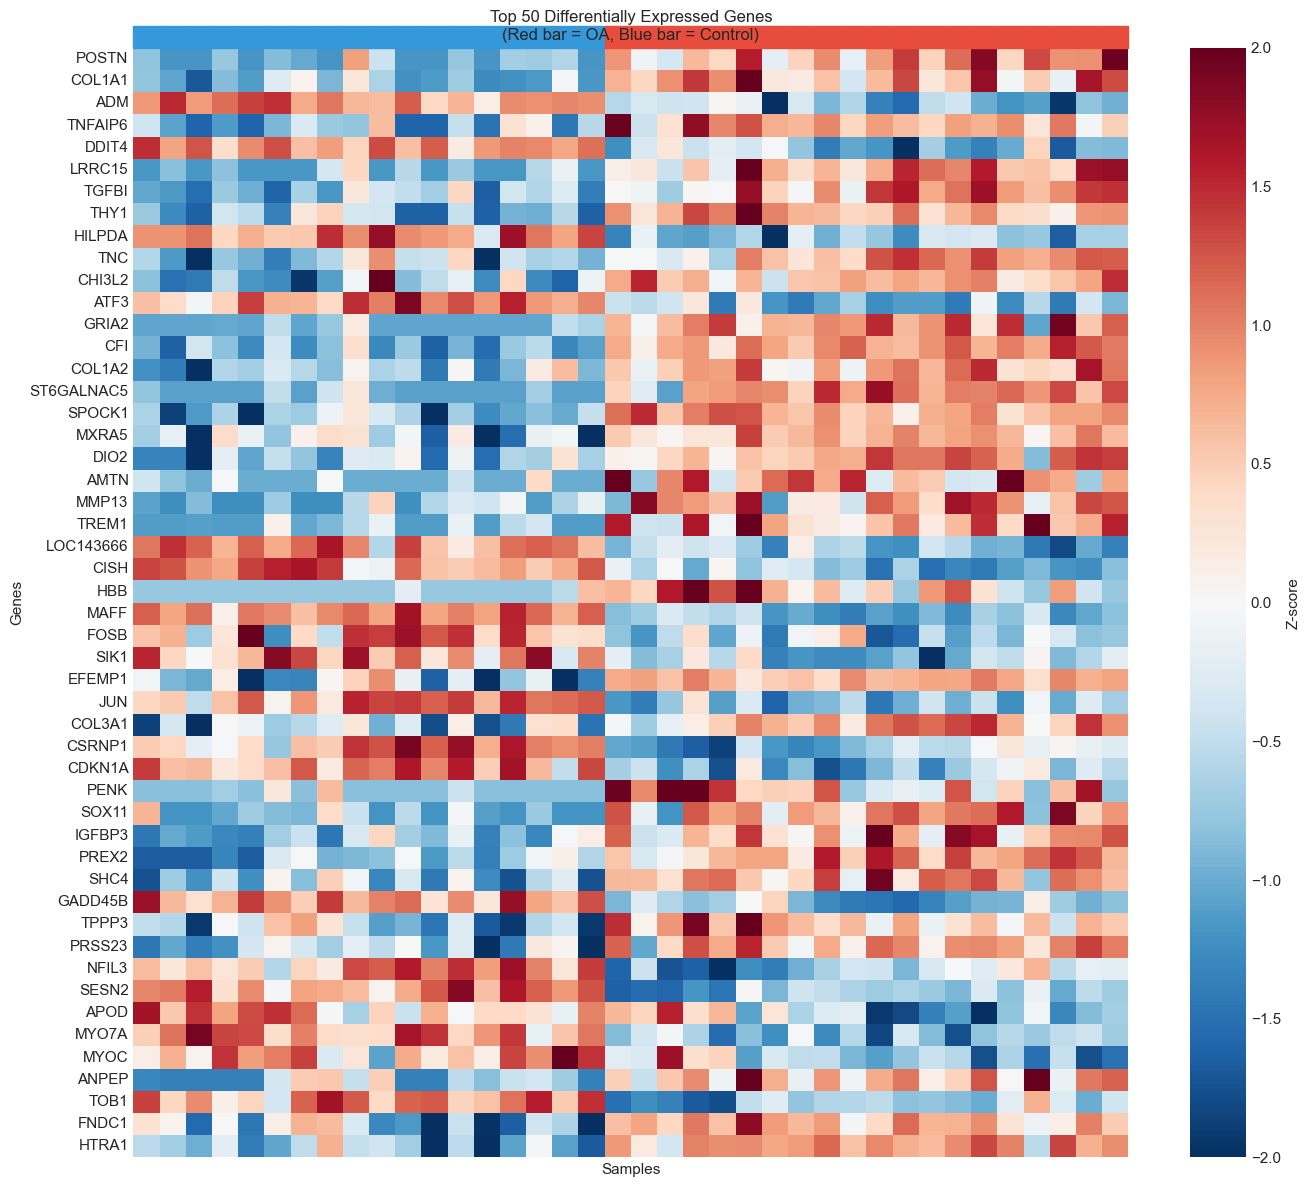


✅ Cell 8 complete. Ready for Cell 9.


In [8]:
"""
CELL 8: HEATMAP OF TOP DE GENES
===============================
Visualize expression patterns of top differentially expressed genes.
"""

print("📊 GENERATING TOP GENES HEATMAP")
print("="*60)
print()

# Select top genes (by absolute fold change, must be significant)
sig_results = de_results[de_results['significance'] != 'Not significant'].copy()
sig_results['abs_log2FC'] = sig_results['log2FC'].abs()
top_genes = sig_results.nlargest(50, 'abs_log2FC')['gene'].tolist()

print(f"   Selecting top 50 DE genes by |log2FC|...")
print(f"   Genes selected: {len(top_genes)}")
print()

if len(top_genes) > 0:
    # Extract expression for these genes
    heatmap_data = expression_df.loc[top_genes]
    
    # Z-score normalize for visualization (per gene)
    heatmap_z = (heatmap_data.T - heatmap_data.mean(axis=1)) / heatmap_data.std(axis=1)
    heatmap_z = heatmap_z.T
    
    # Create annotation for columns (condition)
    col_colors = ['#e74c3c' if s in oa_samples else '#3498db' for s in heatmap_data.columns]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Plot heatmap
    sns.heatmap(
        heatmap_z,
        cmap='RdBu_r',
        center=0,
        vmin=-2,
        vmax=2,
        xticklabels=False,
        yticklabels=True,
        cbar_kws={'label': 'Z-score'},
        ax=ax
    )
    
    # Add condition color bar
    for i, color in enumerate(col_colors):
        ax.add_patch(plt.Rectangle((i, -1), 1, 1, color=color, clip_on=False))
    
    ax.set_title('Top 50 Differentially Expressed Genes\n(Red bar = OA, Blue bar = Control)', fontsize=12)
    ax.set_xlabel('Samples')
    ax.set_ylabel('Genes')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = FIGURES_DIR / 'top_genes_heatmap.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"   💾 Saved: {fig_path}")
    
    plt.show()
else:
    print("   ⚠️ No significant genes found for heatmap")

print()
print("✅ Cell 8 complete. Ready for Cell 9.")

---
## Cell 9: Save Results

In [9]:
"""
CELL 9: SAVE RESULTS
====================
Export differential expression results for downstream analysis.
"""

print("💾 SAVING RESULTS")
print("="*60)
print()

# Save full results
full_results_path = DATA_PROCESSED / 'GSE114007_diff_expr_results.csv'
de_results.to_csv(full_results_path, index=False)
print(f"   ✅ Full results: {full_results_path}")
print(f"      ({len(de_results):,} genes)")

# Save significant genes only
sig_genes_df = de_results[de_results['significance'] != 'Not significant'].copy()
sig_genes_path = DATA_PROCESSED / 'GSE114007_significant_genes.csv'
sig_genes_df.to_csv(sig_genes_path, index=False)
print(f"   ✅ Significant genes: {sig_genes_path}")
print(f"      ({len(sig_genes_df):,} genes)")

# Save ranked gene lists (for GSEA-style analysis)
ranked_genes = de_results[['gene', 'log2FC', 't_statistic', 'p_value', 'FDR']].copy()
ranked_genes = ranked_genes.sort_values('t_statistic', ascending=False)
ranked_genes_path = DATA_PROCESSED / 'GSE114007_ranked_genes.csv'
ranked_genes.to_csv(ranked_genes_path, index=False)
print(f"   ✅ Ranked gene list: {ranked_genes_path}")

# Save upregulated and downregulated separately
up_genes_df = de_results[de_results['significance'] == 'Up in OA'].sort_values('log2FC', ascending=False)
down_genes_df = de_results[de_results['significance'] == 'Down in OA'].sort_values('log2FC', ascending=True)

up_genes_path = DATA_PROCESSED / 'GSE114007_upregulated_in_OA.csv'
down_genes_path = DATA_PROCESSED / 'GSE114007_downregulated_in_OA.csv'

up_genes_df.to_csv(up_genes_path, index=False)
down_genes_df.to_csv(down_genes_path, index=False)

print(f"   ✅ Upregulated in OA: {up_genes_path}")
print(f"      ({len(up_genes_df):,} genes)")
print(f"   ✅ Downregulated in OA: {down_genes_path}")
print(f"      ({len(down_genes_df):,} genes)")

print()
print("✅ Cell 9 complete. Ready for Cell 10.")

💾 SAVING RESULTS

   ✅ Full results: C:\Users\povan\Kairos_Therapeutics\data\processed\GSE114007_diff_expr_results.csv
      (23,710 genes)
   ✅ Significant genes: C:\Users\povan\Kairos_Therapeutics\data\processed\GSE114007_significant_genes.csv
      (1,269 genes)
   ✅ Ranked gene list: C:\Users\povan\Kairos_Therapeutics\data\processed\GSE114007_ranked_genes.csv
   ✅ Upregulated in OA: C:\Users\povan\Kairos_Therapeutics\data\processed\GSE114007_upregulated_in_OA.csv
      (642 genes)
   ✅ Downregulated in OA: C:\Users\povan\Kairos_Therapeutics\data\processed\GSE114007_downregulated_in_OA.csv
      (627 genes)

✅ Cell 9 complete. Ready for Cell 10.


---
## Cell 10: Summary Report

In [10]:
"""
CELL 10: SUMMARY REPORT
=======================
Generate a text summary of differential expression analysis.
"""

print("📝 GENERATING SUMMARY REPORT")
print("="*60)
print()

report_lines = []
report_lines.append("="*60)
report_lines.append("KAIROS ML PROTOTYPE V0 - DIFFERENTIAL EXPRESSION REPORT")
report_lines.append("Dataset: GSE114007 (Knee Cartilage OA vs Control)")
report_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append("="*60)
report_lines.append("")

# Analysis parameters
report_lines.append("ANALYSIS PARAMETERS")
report_lines.append("-"*40)
report_lines.append(f"Statistical test: Welch's t-test")
report_lines.append(f"Multiple testing correction: Benjamini-Hochberg FDR")
report_lines.append(f"Significance threshold: FDR < 0.05, |log2FC| > 1")
report_lines.append(f"OA samples: {len(oa_samples)}")
report_lines.append(f"Control samples: {len(ctrl_samples)}")
report_lines.append("")

# Results summary
report_lines.append("RESULTS SUMMARY")
report_lines.append("-"*40)
report_lines.append(f"Total genes tested: {len(de_results):,}")
report_lines.append(f"Significant genes (FDR < 0.05): {de_results['significant_FDR'].sum():,}")
report_lines.append(f"Significant genes (FDR < 0.05, |log2FC| > 1): {(de_results['significance'] != 'Not significant').sum():,}")
report_lines.append(f"  - Upregulated in OA: {(de_results['significance'] == 'Up in OA').sum():,}")
report_lines.append(f"  - Downregulated in OA: {(de_results['significance'] == 'Down in OA').sum():,}")
report_lines.append("")

# Top genes
report_lines.append("TOP 10 UPREGULATED IN OA")
report_lines.append("-"*40)
up_top = de_results[de_results['significance'] == 'Up in OA'].nlargest(10, 'log2FC')
for _, row in up_top.iterrows():
    report_lines.append(f"  {row['gene']}: log2FC = {row['log2FC']:.2f}, FDR = {row['FDR']:.2e}")
report_lines.append("")

report_lines.append("TOP 10 DOWNREGULATED IN OA")
report_lines.append("-"*40)
down_top = de_results[de_results['significance'] == 'Down in OA'].nsmallest(10, 'log2FC')
for _, row in down_top.iterrows():
    report_lines.append(f"  {row['gene']}: log2FC = {row['log2FC']:.2f}, FDR = {row['FDR']:.2e}")
report_lines.append("")

# Output files
report_lines.append("OUTPUT FILES")
report_lines.append("-"*40)
report_lines.append(f"  GSE114007_diff_expr_results.csv")
report_lines.append(f"  GSE114007_significant_genes.csv")
report_lines.append(f"  GSE114007_ranked_genes.csv")
report_lines.append(f"  GSE114007_upregulated_in_OA.csv")
report_lines.append(f"  GSE114007_downregulated_in_OA.csv")
report_lines.append(f"  volcano_plot.png")
report_lines.append(f"  top_genes_heatmap.png")
report_lines.append("")

# Next steps
report_lines.append("NEXT STEPS")
report_lines.append("-"*40)
report_lines.append("  1. Pathway enrichment analysis (MSigDB Hallmarks)")
report_lines.append("  2. Intersection with aging gene signatures")
report_lines.append("  3. Filter for secreted factors (MSC-deliverable)")
report_lines.append("  4. Prioritize therapeutic candidates")
report_lines.append("")
report_lines.append("="*60)

# Print and save
report_text = "\n".join(report_lines)
print(report_text)

report_path = REPORTS_DIR / 'diff_expr_summary.txt'
with open(report_path, 'w') as f:
    f.write(report_text)
print()
print(f"💾 Report saved: {report_path}")

print()
print("✅ Cell 10 complete. Notebook 03 finished!")

📝 GENERATING SUMMARY REPORT

KAIROS ML PROTOTYPE V0 - DIFFERENTIAL EXPRESSION REPORT
Dataset: GSE114007 (Knee Cartilage OA vs Control)
Generated: 2025-12-26 19:14:45

ANALYSIS PARAMETERS
----------------------------------------
Statistical test: Welch's t-test
Multiple testing correction: Benjamini-Hochberg FDR
Significance threshold: FDR < 0.05, |log2FC| > 1
OA samples: 20
Control samples: 18

RESULTS SUMMARY
----------------------------------------
Total genes tested: 23,710
Significant genes (FDR < 0.05): 3,270
Significant genes (FDR < 0.05, |log2FC| > 1): 1,269
  - Upregulated in OA: 642
  - Downregulated in OA: 627

TOP 10 UPREGULATED IN OA
----------------------------------------
  POSTN: log2FC = 5.92, FDR = 1.67e-07
  COL1A1: log2FC = 5.17, FDR = 5.93e-07
  TNFAIP6: log2FC = 4.09, FDR = 2.42e-06
  LRRC15: log2FC = 4.04, FDR = 2.10e-07
  TGFBI: log2FC = 4.02, FDR = 6.94e-06
  THY1: log2FC = 3.94, FDR = 3.55e-07
  TNC: log2FC = 3.73, FDR = 1.34e-04
  CHI3L2: log2FC = 3.66, FDR = 

---
## Cell 11: Final Checkpoint

In [11]:
"""
CELL 11: FINAL CHECKPOINT
=========================
Summary and next steps.
"""

print("="*60)
print("🎯 NOTEBOOK 03 COMPLETE - FINAL CHECKPOINT")
print("="*60)
print()

print("📊 DIFFERENTIAL EXPRESSION SUMMARY:")
print("-"*40)
print(f"   Total genes: {len(de_results):,}")
print(f"   Significant (FDR < 0.05, |log2FC| > 1): {(de_results['significance'] != 'Not significant').sum():,}")
print(f"   Upregulated in OA: {(de_results['significance'] == 'Up in OA').sum():,}")
print(f"   Downregulated in OA: {(de_results['significance'] == 'Down in OA').sum():,}")

print()
print("📁 OUTPUT FILES:")
print("-"*40)
output_files = [
    DATA_PROCESSED / 'GSE114007_diff_expr_results.csv',
    DATA_PROCESSED / 'GSE114007_significant_genes.csv',
    DATA_PROCESSED / 'GSE114007_ranked_genes.csv',
    FIGURES_DIR / 'volcano_plot.png',
    FIGURES_DIR / 'top_genes_heatmap.png',
    REPORTS_DIR / 'diff_expr_summary.txt'
]
for f in output_files:
    if f.exists():
        size_kb = f.stat().st_size / 1024
        print(f"   ✅ {f.name} ({size_kb:.1f} KB)")

print()
print("🚀 NEXT STEPS:")
print("-"*40)
print("   1. Commit this notebook to GitHub")
print("   2. Notebook 04: Pathway Enrichment Analysis")
print("   3. Notebook 05: Age-Disease Intersection Analysis")
print("   4. Notebook 06: Therapeutic Target Prioritization")

print()
print("📋 GIT COMMANDS:")
print("-"*40)
print('   git add notebooks/Notebook_03_Differential_Expression.ipynb')
print('   git add data/processed/GSE114007_*.csv')
print('   git add reports/')
print('   git commit -m "Add Notebook 03: Differential Expression (X up, Y down in OA)"')
print('   git push origin main')

print()
print(f"🕐 Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

🎯 NOTEBOOK 03 COMPLETE - FINAL CHECKPOINT

📊 DIFFERENTIAL EXPRESSION SUMMARY:
----------------------------------------
   Total genes: 23,710
   Significant (FDR < 0.05, |log2FC| > 1): 1,269
   Upregulated in OA: 642
   Downregulated in OA: 627

📁 OUTPUT FILES:
----------------------------------------
   ✅ GSE114007_diff_expr_results.csv (4549.0 KB)
   ✅ GSE114007_significant_genes.csv (263.7 KB)
   ✅ GSE114007_ranked_genes.csv (1796.4 KB)
   ✅ volcano_plot.png (299.2 KB)
   ✅ top_genes_heatmap.png (133.9 KB)
   ✅ diff_expr_summary.txt (2.2 KB)

🚀 NEXT STEPS:
----------------------------------------
   1. Commit this notebook to GitHub
   2. Notebook 04: Pathway Enrichment Analysis
   3. Notebook 05: Age-Disease Intersection Analysis
   4. Notebook 06: Therapeutic Target Prioritization

📋 GIT COMMANDS:
----------------------------------------
   git add notebooks/Notebook_03_Differential_Expression.ipynb
   git add data/processed/GSE114007_*.csv
   git add reports/
   git commit -m "Ad

---
## End of Notebook 03

**Summary:**
- Performed differential expression analysis (OA vs Control)
- Applied Welch's t-test with FDR correction
- Generated volcano plot and heatmap
- Saved ranked gene lists for downstream analysis

**Key Outputs:**
- Full DE results with fold changes and p-values
- Filtered significant gene lists (up/down in OA)
- Ranked gene list for pathway analysis

**Next:** Notebook 04 - Pathway Enrichment Analysis